<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Implement-matrix-factorisation-using-gradient-descent-(take-2)" data-toc-modified-id="Implement-matrix-factorisation-using-gradient-descent-(take-2)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Implement matrix factorisation using gradient descent (take 2)</a></span><ul class="toc-item"><li><span><a href="#Implement-gradient-based-factorisation-using-PyTorch’s-AD" data-toc-modified-id="Implement-gradient-based-factorisation-using-PyTorch’s-AD-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Implement gradient-based factorisation using PyTorch’s AD</a></span></li><li><span><a href="#Factorise-and-compute-reconstruction-error-on-real-data" data-toc-modified-id="Factorise-and-compute-reconstruction-error-on-real-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Factorise and compute reconstruction error on real data</a></span></li><li><span><a href="#Compare-against-PCA" data-toc-modified-id="Compare-against-PCA-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Compare against PCA</a></span></li></ul></li><li><span><a href="#A-simple-MLP" data-toc-modified-id="A-simple-MLP-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>A simple MLP</a></span><ul class="toc-item"><li><span><a href="#Implement-the-MLP" data-toc-modified-id="Implement-the-MLP-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Implement the MLP</a></span></li><li><span><a href="#Test-the-MLP" data-toc-modified-id="Test-the-MLP-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Test the MLP</a></span></li></ul></li></ul></div>

# Lab 2 Exercise - PyTorch Autograd

In [27]:
import numpy as np
import torch
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple
sns.set()

## Implement matrix factorisation using gradient descent (take 2)

In [26]:
m, n, rank = 50, 15, 4

A = torch.randn(m, n, requires_grad=True) 

#A = torch.tensor([[0.3374, 0.6005, 0.1735],
#                  [3.3359, 0.0492, 1.8374],
#                  [2.9407, 0.5301, 2.2620]])

### Implement gradient-based factorisation using PyTorch’s AD

In [28]:
def sgd_foctorise_ad(A, rank, num_epochs=1000, lr=0.01) -> Tuple[torch.Tensor, torch.Tensor]:
    m, n = A.shape[0], A.shape[1]
    U = torch.randn(m, rank, requires_grad=True)
    V = torch.randn(n, rank, requires_grad=True)
    Eplot = np.zeros((num_epochs, 1))
    for epoch in range(num_epochs):
        loss = torch.nn.functional.mse_loss(A, U @ V.t(), reduction='sum')
        U.grad, V.grad = None, None
        loss.backward()
        U.data -= lr*U.grad
        V.data -= lr*V.grad
        Eplot[epoch] = loss.detach().numpy() #e
                
    plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(Eplot)
    plt.title("Matrix Factorisation using Gradient Descent", fontsize=20)
    plt.xlabel("Iteration Number", fontsize=18)
    plt.ylabel("Reconstruction Loss", fontsize=18)
    plt.savefig("AD_Loss.svg", format='svg', dpi=1200, bbox_inches='tight')
    plt.show()
    print("Final Loss:", Eplot[len(Eplot)-1])
    return U, V 

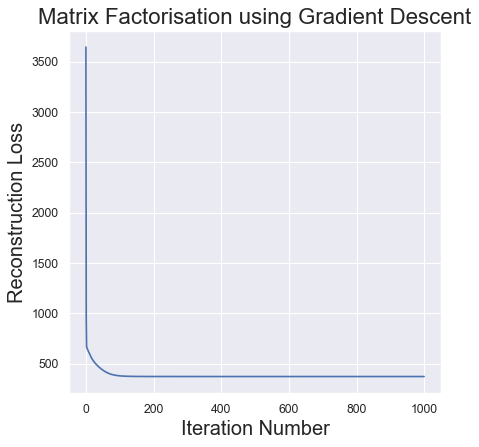

Final Loss: [371.03570557]


In [29]:
Uhat, V = sgd_foctorise_ad(A, 4, num_epochs=1000, lr=0.01)

### Factorise and compute reconstruction error on real data

In [35]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_csv( 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data' , header=None )
data = torch.tensor(df.iloc[:, [0,1,2,3]].values, dtype=torch.float)
data = data - data.mean(dim=0)

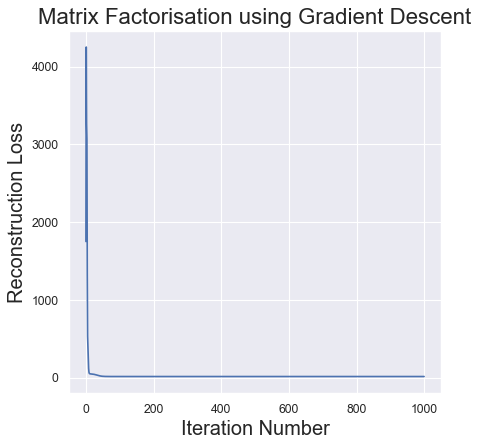

Final Loss: [15.22883034]


In [39]:
Uhat, V = sgd_foctorise_ad(data, 2, num_epochs=1000, lr=0.01)

In [40]:
U, S, V = torch.svd(data)

rec = U[:, 0:2] @ torch.diag(S[0:2]) @ V[:, 0:2].t()

torch.nn.functional.mse_loss(data, rec, reduction='sum')

tensor(15.2288)

In [41]:
U, S, V = torch.svd(data)
S[2] = 0.0
S[3] = 0.0

rec = U @ torch.diag(S) @ V.t()

torch.nn.functional.mse_loss(data, rec, reduction='sum')

tensor(15.2288)

### Compare against PCA

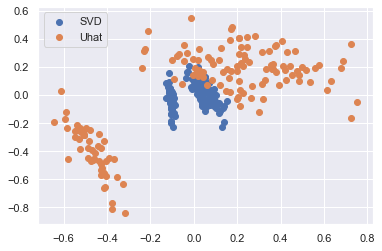

In [235]:
# Uhat, V = sgd_foctorise_ad(data, 2, num_epochs=1000, lr=0.01)
# U, S, V = torch.svd(data)
plt.scatter(U[:, 0], U[:, 1], label='SVD')
plt.scatter(Uhat[:, 0].detach().numpy(), Uhat[:, 1].detach().numpy(), label='Uhat')
plt.legend()

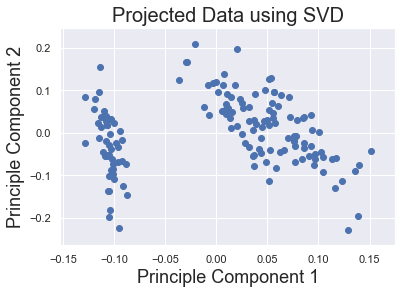

In [42]:
plt.scatter(U[:, 0], U[:, 1])
plt.title("Projected Data using SVD", fontsize=20)
plt.xlabel("Principle Component 1", fontsize=18)
plt.ylabel("Principle Component 2", fontsize=18)
plt.savefig("SVD.svg", format='svg', dpi=1200, bbox_inches='tight')
plt.show()

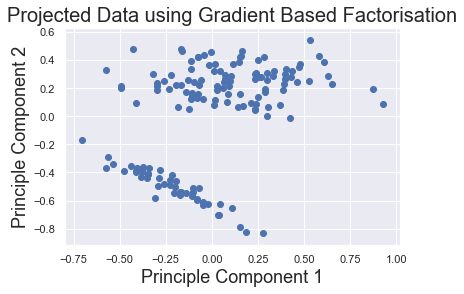

In [44]:
plt.scatter(Uhat[:, 0].detach().numpy(), Uhat[:, 1].detach().numpy())
plt.title("Projected Data using Gradient Based Factorisation", fontsize=20)
plt.xlabel("Principle Component 1", fontsize=18)
plt.ylabel("Principle Component 2", fontsize=18)
plt.savefig("GBF.svg", format='svg', dpi=1200, bbox_inches='tight')
plt.show()

## A simple MLP

In [45]:
df = pd.read_csv( 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data' , header=None )
df = df.sample(frac =1) #shuffle
# add label indices column
mapping = {k : v for v , k in enumerate(df[4].unique( ))}
df[5] = df[4].map(mapping)
# normalise data
alldata = torch.tensor(df.iloc[:,[0,1,2,3]].values, dtype=torch.float)
alldata = (alldata - alldata.mean(dim=0))/alldata.var(dim=0)
# create datasets
targetstr = torch.tensor(df.iloc[:100,5].values, dtype=torch.long)
targetsva = torch.tensor(df.iloc[100:,5].values, dtype=torch.long)
datatr = alldata[:100]
datava = alldata[100:]

### Implement the MLP

In [57]:
def mlp(data, targets, num_epochs=100, lr=0.01, plot=False):
    W1 = torch.randn(4, 12, requires_grad=True)
    W2 = torch.randn(12, 3, requires_grad=True)
    b1 = torch.tensor(0.0, requires_grad=True) 
    b2 = torch.tensor(0.0, requires_grad=True)
    Eplot = np.zeros((num_epochs, 1))
    for epoch in range(num_epochs):
        W1.grad, W2.grad, b1.grad, b2.grad = None, None, None, None
        logits = torch.relu(data @ W1 + b1) @ W2 + b2
        loss = torch.nn.functional.cross_entropy(logits, targets)
        loss.backward()
        W1.data -= lr*W1.grad
        W2.data -= lr*W2.grad
        b1.data -= lr*b1.grad
        b2.data -= lr*b2.grad
        Eplot[epoch] = loss.detach().numpy() 
                
    if plot==True:
        plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', 
                   edgecolor='k')
        plt.plot(Eplot)
        plt.title("Gradient Descent MLP", fontsize=20)
        plt.xlabel("Iteration Number", fontsize=18)
        plt.ylabel("Loss", fontsize=18)
        plt.savefig("MLP.svg", format='svg', dpi=1200, bbox_inches='tight')
        plt.show()
        print("Final Loss:", Eplot[len(Eplot)-1])
    
    return W1, W2, b1, b2

In [58]:
def accuracy(logits, targets):
    sm = torch.nn.Softmax(dim=1)
    probabilities = sm(logits) 
    _, predicted = torch.max(probabilities, 1)
    count = [1 for i, j in zip(predicted, targets.long()) if i == j]
    correct, total = sum(count), len(targets)
    return ((100.0 * correct) / total)

### Test the MLP

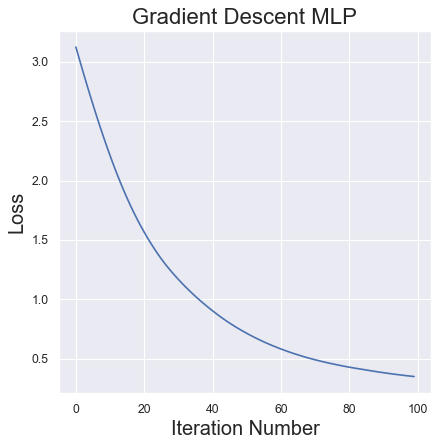

Final Loss: [0.34859067]


In [48]:
W1, W2, b1, b2 = mlp(datatr, targetstr, plot=True)

In [49]:
logits = torch.relu(datatr @ W1 + b1) @ W2 + b2
loss = torch.nn.functional.cross_entropy(logits, targetstr)
print(loss)
accuracy(logits, targetstr)

tensor(0.3456, grad_fn=<NllLossBackward>)


85.0

In [50]:
logits = torch.relu(datava @ W1 + b1) @ W2 + b2
loss = torch.nn.functional.cross_entropy(logits, targetsva)
print(loss)
accuracy(logits, targetsva)

tensor(0.5650, grad_fn=<NllLossBackward>)


78.0

In [115]:
tr_loss, tr_acc = [], []
va_loss, va_acc = [], []
for i in range(0, 50000):
    W1, W2, b1, b2 = mlp(datatr, targetstr)
    logits = torch.relu(datatr @ W1 + b1) @ W2 + b2
    loss = torch.nn.functional.cross_entropy(logits, targetstr)
    acc = accuracy(logits, targetstr)
    logits = torch.relu(datava @ W1 + b1) @ W2 + b2
    loss2 = torch.nn.functional.cross_entropy(logits, targetsva)
    acc2 = accuracy(logits, targetsva)
    tr_loss.append(loss.detach().numpy())
    tr_acc.append(acc)
    va_loss.append(loss2.detach().numpy())
    va_acc.append(acc2)
    
print("Training Report: ")
print("Mean Loss: ", np.mean(tr_loss), "Mean accuracy: ", np.mean(tr_acc))
print("Min Loss: ", min(tr_loss), "Min accuracy: ", min(tr_acc))
print("Max Loss: ", max(tr_loss), "Max accuracy: ", max(tr_acc))
print("Validation Report: ")
print("Mean Loss: ", np.mean(va_loss), "Mean accuracy: ", np.mean(va_acc))
print("Min Loss: ", min(va_loss), "Min accuracy: ", min(va_acc))
print("Max Loss: ", max(va_loss), "Max accuracy: ", max(va_acc))

Training Report: 
Mean Loss:  0.5838449 Mean accuracy:  76.3618
Min Loss:  0.21450356 Min accuracy:  21.0
Max Loss:  2.085731 Max accuracy:  93.0
Validation Report: 
Mean Loss:  0.741351 Mean accuracy:  73.48708
Min Loss:  0.21885277 Min accuracy:  6.0
Max Loss:  2.861536 Max accuracy:  94.0


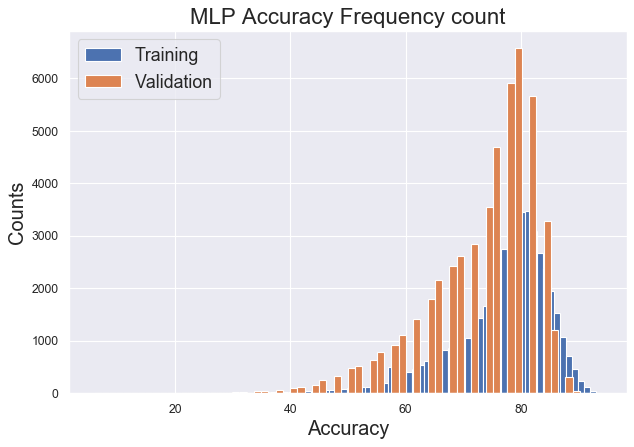

In [122]:
plt.figure(num=None, figsize=(9, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(tr_acc, bins=70, label='Training')
plt.hist(va_acc, bins=70, label='Validation') 
plt.title("MLP Accuracy Frequency count", fontsize=20)
plt.ylabel('Counts', fontsize=18)
plt.xlabel('Accuracy', fontsize=18)
plt.legend(fontsize=16)
plt.savefig("frequency.svg", format='svg', dpi=1200, bbox_inches='tight')
plt.show()

In [59]:
def mlp2(data, targets, data2, targets2, num_epochs=100, lr=0.01, plot=False):
    W1 = torch.randn(4, 12, requires_grad=True)
    W2 = torch.randn(12, 3, requires_grad=True)
    b1 = torch.tensor(0.0, requires_grad=True) 
    b2 = torch.tensor(0.0, requires_grad=True)
    tr_loss, tr_acc = [], []
    va_loss, va_acc = [], []
    Eplot = np.zeros((num_epochs, 1))
    for epoch in range(num_epochs):
        logits = torch.relu(data @ W1 + b1) @ W2 + b2
        loss = torch.nn.functional.cross_entropy(logits, targets)
        W1.grad, W2.grad, b1.grad, b2.grad = None, None, None, None
        loss.backward()
        W1.data -= lr*W1.grad
        W2.data -= lr*W2.grad
        b1.data -= lr*b1.grad
        b2.data -= lr*b2.grad
        acc = accuracy(logits, targets)
        
        logits2 = torch.relu(data2 @ W1 + b1) @ W2 + b2
        loss2 = torch.nn.functional.cross_entropy(logits2, targets2)
        acc2 = accuracy(logits2, targets2)
        
        Eplot[epoch] = loss.detach().numpy() 
        tr_loss.append(loss.detach().numpy())
        tr_acc.append(acc)
        va_loss.append(loss2.detach().numpy())
        va_acc.append(acc2)
        
        
                
    if plot==True:
        plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', 
                   edgecolor='k')
        plt.plot([i for i in range(num_epochs)], tr_loss, label='Training')
        plt.plot([i for i in range(num_epochs)], va_loss, label='Validation')
        plt.title("Gradient Descent MLP Loss", fontsize=20)
        plt.xlabel("Iteration Number", fontsize=18)
        plt.ylabel("Loss", fontsize=18)
        plt.legend()
        plt.savefig("MLP_Loss.svg", format='svg', dpi=1200, bbox_inches='tight')
        plt.show()
        
        plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', 
                   edgecolor='k')
        plt.plot([i for i in range(num_epochs)], tr_acc, label='Training')
        plt.plot([i for i in range(num_epochs)], va_acc, label='Validation')
        plt.title("Gradient Descent MLP Accuracy", fontsize=20)
        plt.xlabel("Iteration Number", fontsize=18)
        plt.ylabel("Accuracy (%)", fontsize=18)
        plt.legend()
        plt.savefig("MLP_Accuracy.svg", format='svg', dpi=1200, bbox_inches='tight')
        plt.show()
        print("Final Loss:", Eplot[len(Eplot)-1])
    
    return W1, W2, b1, b2

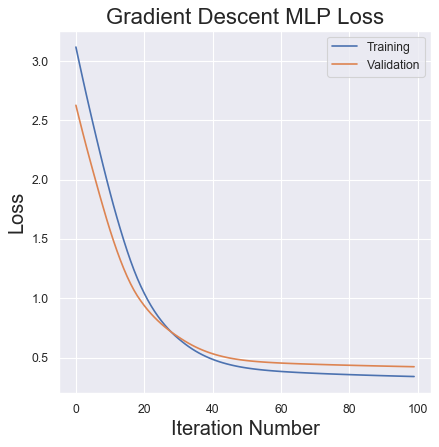

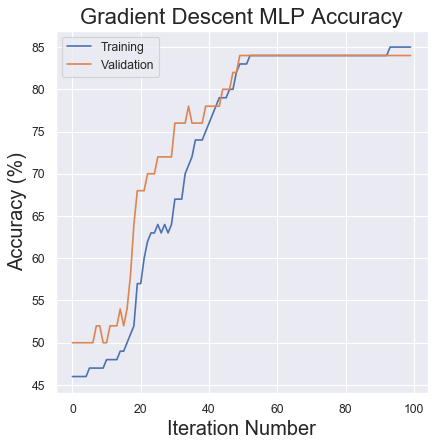

Final Loss: [0.33968812]


In [102]:
W1, W2, b1, b2 = mlp2(datatr, targetstr, datava, targetsva, plot=True)